<a href="https://colab.research.google.com/github/alekswheeler/datasci_home_work/blob/main/Especifica%C3%A7%C3%A3o_2024_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático

O objetivo geral deste trabalho é praticar os conceitos discutidos em sala de aula, principalmente: representação e pré-processamento de dados textuais; redução de dimensionalidade e algoritmos de agrupamento.

## Conjunto de Dados

Para esse trabalho utilizaremos um conjunto de dados de filmes. Os dados foram obtidos de várias fontes, incluindo IMDB.

O conjunto de dados que vocês deverão usar encontra-se no AVA da disciplina. Os dados estão organizados um arquivo (`.csv`) com as seguintes colunas:

* **genres** - gêneros a que um filme pertence. Veja que um filme pode estar associado a mais de um gênero (`str`);
* **sinopse** - sinopse do filme (`str`);
* **startYear** - ano de lançamento do filme (`int`);
* **primaryTitle** - título do filme (`str`);
* **runtimeMinutes** - duração do filme, em minutos (`int`);
* **averageRating** - média das avaliações do filme (`float`);
* **numVotes** - número de avaliações do filme (`int`);
* **actors_names** - atores/atrizes principais (`str`);
* **directors_names** - diretores(as) do filme (`str`).

**Observação:** esse conjunto de dados é uma versão transformada dos dados originais. Por exemplo, gêneros muito populares ou raros foram removidos.

**ATENÇÃO**
É possível que seu computador não consiga lidar com o conjunto de dados completo. Se for o caso, faça uma amostra aleatória de filmes do conjunto de dados. Deixe claro o processo de amostragem, o tamanho das amostras finais que considerou no trabalho e as especificações do computador utilizado.

Os comandos abaixo mostram como os dados podem ser obtidos e carregados em um `DataFrame`.

In [11]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv



--2025-02-10 23:19:09--  https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg
Resolving docs.google.com (docs.google.com)... 172.253.122.102, 172.253.122.101, 172.253.122.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.122.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download [following]
--2025-02-10 23:19:09--  https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11380332 (11M) [application/octet-stream]
Saving to: ‘filmes.csv’

filmes.csv          100%[===================>]  10.85M  69.3MB/s   

In [12]:
import pandas as pd
df = pd.read_csv("filmes.csv")

In [13]:
df.head()
a = df['sinopse']

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
D = ["É escória échange", "this is 1980  a another people and", "example example example"]

vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-ZÀ-ÖØ-öø-ÿ]+\b', stop_words='english')
vectorizer.fit_transform(D)
vectorizer.get_feature_names_out()

array(['escória', 'example', 'people', 'é', 'échange'], dtype=object)

## Objetivo

Vocês deverão utilizar aprendizado não supervisionado (neste caso, agrupamento) para investigar se há relação entre a **sinopse** de um filme e o(s) **gênero(s)** a que pertence.

De forma mais específica, vocês deverão agrupar os filmes de acordo suas sinopses e, após isso, verificar a distribuição dos gêneros em cada grupo. Ou seja, se os filmes pertencentes ao mesmo grupo possuem o(s) mesmo(s) gênero(s) ou se as distribuições de gêneros de grupos diferentes são distintas.

## Trabalho

Antes de fazer o pré-processamento de dados a ideia é que vamos dividir a base de dados em pedaços menores mantendo a proporção da base de dados original ([StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).

In [15]:
X = df.drop(columns=['genres'])
y = df['genres']

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

SEED = 42
np.random.seed(SEED)

# Dividindo em 10 Folds estratificados
skf = StratifiedKFold(n_splits=3)

# Guardar todos os folds
folds = list(skf.split(X, y))

# Escolher um fold aleatório
random_fold = np.random.RandomState(SEED).choice(len(folds))

# Separar os dados do fold escolhido
train_idx, test_idx = folds[random_fold]
rand_X, rand_y = X.iloc[test_idx], y.iloc[test_idx]

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [17]:
# Pegando apenas a característica sinopse da amostra
rand_X = rand_X['sinopse']

### Criando matriz de tokens para trabalhar com TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  # Stemmer para inglês


nltk.data.path.append('/usr/local/nltk_data')

# Baixar recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')

# Criar stemmer e stop words em inglês
stemmer = PorterStemmer()
stop_words_en = stopwords.words('english')

# Função de pré-processamento com stemming e remoção de números
def tokenize_stem(text):
    tokens = nltk.word_tokenize(text, language='english')  # Tokeniza o texto
    tokens = [word for word in tokens if word.isalpha()]  # Remove números e símbolos
    tokens = [stemmer.stem(word) for word in tokens]  # Aplica stemming
    tokens = [word for word in tokens if word not in stop_words_en]  # Remove stop words
    return tokens

# Criando o TfidfVectorizer com Stemming e Remoção de Números
vectorizer = TfidfVectorizer(
    tokenizer=tokenize_stem,  # Usa a função personalizada
    token_pattern=None  # Ignorado quando usamos tokenizer personalizado
)

# Ajusta o vectorizer no conjunto completo (ou apenas no treino, se preferir)
vectorizer.fit(rand_X)

# Transforma os dados de rand_X
rand_X_tfidf = vectorizer.transform(rand_X)

tfidf_dataframe = pd.DataFrame(rand_X_tfidf.todense(), columns = vectorizer.get_feature_names_out())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [31]:
# vectorizer.get_feature_names_out()[500:900]
tfidf_dataframe.to_csv('tfidf_dataframe.csv', index=False)

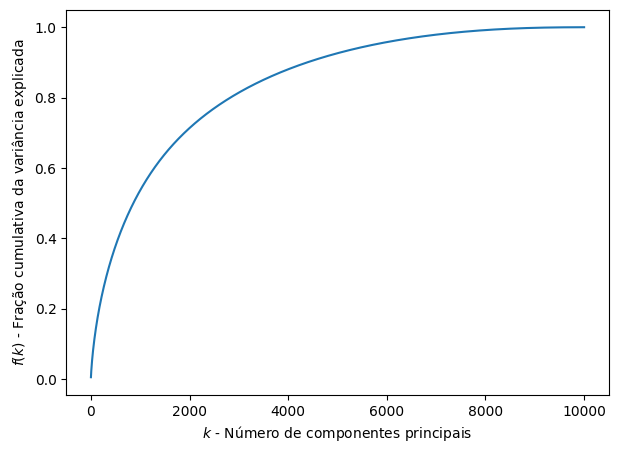

In [34]:
# Usando PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import pandas as pd

pca = PCA(n_components = 10000)
pca.fit(tfidf_dataframe)

#@title
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

## Metodologia

Para atingir o objetivo proposto, vocês deverão seguir ao menos os seguintes passos:
1. Pré-processamento dos dados textuais;
2. Construção da matriz de TF-IDF;
3. Redução de dimensionalidade, via PCA (Leia também sobre o *Truncated SVD*: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html);
4. Aplicação de ao menos dois algoritmos de agrupamento vistos na disciplina;
5. Validação da metodologia utilizada;
6. Interpretação dos resultados.

**PS:** essas são as exigências mínimas. Caso vocês queiram fazer/propor algo extra, será permitido (e pode ajudar na nota se a proposta for relevante).

## Resultados esperados

Dois tipo de resultados são esperados: validação e análise.

### Resultados de validação

O trabalho deve conter resultados mostrando que os algoritmos (e respectivos parâmetros) foram escolhidos e utilizados de forma correta. Entre os pontos importantes:
1. Como foi escolhido o número de componentes principais para o PCA? O número de componentes principais tem um impacto significativo nos resultados? É necessário usar PCA neste trabalho?
2. Como o número de grupos para cada algoritmo de agrupamento foi definido? A escolha do algoritmo de agrupamento impacta significativamente os resultados? E o número de grupos?

Fará parte da avaliação a forma que escolherem para validar a metodologia. Vocês podem recorrer a visualizações interessantes, medidas internas...

### Análise

Após validar e entender os resultados (e se convencerem que estão corretos e fazem sentido), você deve responder as perguntas principais:
- Há diferença nas distribuições de gêneros dos filmes em grupos diferentes?
- Há relação entre as sinopses dos filmes e os respectivos gêneros?

- **Opcional, pontuação extra:** se, além das sinopses, você também considerar as demais informações no conjunto de dados (avaliações, atores/atrizes, diretores(as), título, ano e duração) para os algoritmos de agrupamento, é possível encontrar uma melhor associação entre os grupos e os gêneros dos filmes?
Novamente, recorra às ferramentas que já vimos no curso para responder essa pergunta: visualizações, medidas externas... **soluções que tiverem achados interessantes nessa parte do trabalho ganharão ponto extra**.

## Observações importantes

1. Durante a fase de agrupamento, apenas a informação da sinopse deve ser utilizada. A informação de **gênero dos filmes** deve ser usada apenas após a fase de agrupamento para validar e analisar os resultados.
2. Vocês podem usar todas as bibliotecas Python que venho mostrando em aula. Caso queiram usar algo muito diferente (por exemplo, alguma biblioteca de uso comercial), perguntem ao professor antes (em nosso fórum do AVA).
3. Lembrem-se que este trabalho vale 30% da nota do semestre. Vocês serão avaliados pela:
  - Qualidade dos resultados quantitativos;
  - Escolha e condução da metodologia;
  - Uso de visualizações informativas e bem feitas;
  - Explicação dos passos seguidos e das decisões tomadas;
  - Justificativas para as decisões tomadas;
  - Análise dos resultados;
  - Conclusões.
4. Qualquer colaboração, entre grupos ou de fontes externas, deve ser citada e mencionada no trabalho. **NÃO HAVERÁ TOLERÂNCIA PARA COLABORAÇÕES INDEVIDAS!**

## Grupos

- **Graduação:** até 3 pessoas
- **Pós-graduação:** individual

## Entrega

- **Linguagem de programação:** Python
- **O que entregar:** um *Jupyter Notebook*, contendo texto, código e resultados. Deve ser possível que o professor execute o seu código, mas o arquivo ``.ipynb`` submetido já deve conter todos os resultados (i.e., deve ser possível corrigir seu trabalho apenas abrindo o arquivo). Apenas um integrante do grupo deve fazer a submissão no AVA. Lembrem-se de colocar a informação de todos os integrantes do grupo (nome, matrícula e e-mail).

## Dúvidas?

Postem em nosso fórum do AVA!